In [24]:
# Jupyter notebook magic to reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import sys

sys.path.append(
    "../",
)  # path to the src with the functions

## Select a file + trial from the dataset


In [26]:
import pickle

# Path to the pickle file
pkl_path_1 = "../data/Data05_External_noise/gna_1.00_gk_1.00_noise_1.00/00.pkl"  # Baseline at 20X external input

# Load the pickle file
# load path 1
try:
    with open(pkl_path_1, "rb") as file:
        data = pickle.load(file)
    print("Data loaded successfully.")
except Exception as e:
    print("Error loading the file:", e)

Data loaded successfully.


In [27]:
import matplotlib.pyplot as plt
import numpy as np
from src.SanjayCode import find_depolarization_block
from scipy.ndimage import gaussian_filter1d

## Find DPB onset


In [28]:
# Calculate the DPB onset in basket cells
cell_range = range(800, 1000)  # Basket cells GID range
depolarization_onset = find_depolarization_block(data["simData"], cell_range)

if depolarization_onset is not None:
    print(f"Depolarization block onset detected at {depolarization_onset} ms")
else:
    print("No depolarization block detected.")

Depolarization block onset detected at 848.6 ms


## Burst detection (last before and 1st after DPB)


In [29]:
def detect_bursts(activity, threshold):
    """
    Detects bursts in the convolved activity based on a fixed threshold.
    Returns the indices of the start and end of bursts.
    """
    above_threshold = activity > threshold
    diff = np.diff(above_threshold.astype(int))
    start_indices = np.where(diff == 1)[0] + 1  # Start of burst
    end_indices = np.where(diff == -1)[
        0
    ]  # End of burst if activity ends exactly at threshold

    # Adding handling for bursts that might start at the beginning or end at the end of the activity array
    if above_threshold[0]:
        start_indices = np.insert(start_indices, 0, 0)  # If starts with a burst
    if above_threshold[-1]:
        end_indices = np.append(end_indices, len(activity) - 1)  # If ends with a burst

    valid_bursts = [
        (start, end)
        for start, end in zip(start_indices, end_indices)
        if end - start
        >= 3  # Ensuring the burst lasts for at least the duration of 3 bins
    ]
    return valid_bursts

In [30]:
def convolve_spike_activity_DPB_with_bursts(
    simData, depolarization_onset, window=100, resolution=1, sigma=1, fixed_threshold=1
):
    gids = {"Pyr": range(800), "Bwb": range(800, 1000)}
    time_bins = np.arange(
        depolarization_onset - window,
        depolarization_onset + window + resolution,
        resolution,
    )

    convolved_activities = {}
    burst_info = {}

    for cell_type, gid_range in gids.items():
        spike_times = np.concatenate(
            [simData[gid].spike_times for gid in gid_range if gid in simData]
        )
        spike_counts, _ = np.histogram(spike_times, bins=time_bins)
        convolved_activity = gaussian_filter1d(spike_counts, sigma=sigma / resolution)

        bursts = detect_bursts(convolved_activity, fixed_threshold)

        last_burst_before_dpb = None
        first_burst_after_dpb = None
        for start, end in bursts:
            # Burst starts before DPB and ends before or after DPB
            if time_bins[start] < depolarization_onset:
                if (
                    last_burst_before_dpb is None
                    or time_bins[start] > time_bins[last_burst_before_dpb[0]]
                ):
                    last_burst_before_dpb = (
                        start,
                        (
                            end
                            if time_bins[end] < depolarization_onset
                            else np.searchsorted(
                                time_bins, depolarization_onset, side="right"
                            )
                            - 1
                        ),
                        max(convolved_activity[start:end]),
                    )
            # First burst after DPB
            elif (
                time_bins[start] > depolarization_onset
                and first_burst_after_dpb is None
            ):
                first_burst_after_dpb = (
                    time_bins[start],
                    time_bins[end],
                    max(convolved_activity[start:end]),
                )
                break  # Stop after finding the first burst after DPB

        # Adjusting the tuple values to time bins for consistency
        if last_burst_before_dpb is not None:
            last_burst_before_dpb = (
                time_bins[last_burst_before_dpb[0]],
                time_bins[last_burst_before_dpb[1]],
                last_burst_before_dpb[2],
            )

        convolved_activities[cell_type] = (time_bins[:-1], convolved_activity)
        burst_info[cell_type] = {
            "last_burst_before_dpb": last_burst_before_dpb,
            "first_burst_after_dpb": first_burst_after_dpb,
        }

    return convolved_activities, burst_info

In [31]:
convolved_activities, burst_info = convolve_spike_activity_DPB_with_bursts(
    data["simData"], depolarization_onset
)

In [32]:
print(burst_info)

{'Pyr': {'last_burst_before_dpb': (827.6, 834.6, 189), 'first_burst_after_dpb': (877.6, 893.6, 145)}, 'Bwb': {'last_burst_before_dpb': (826.6, 832.6, 58), 'first_burst_after_dpb': None}}


In [33]:
def plot_convolved_activities_and_bursts(
    convolved_activities, burst_info, depolarization_onset
):
    """
    Plots the convolved spike activities and highlights the detected bursts.

    Parameters:
    convolved_activities (dict): A dictionary with cell populations as keys and tuples of (time_bins, convolved_activity) as values.
    burst_info (dict): A dictionary with cell populations as keys and burst information as values.
    """
    plt.figure(figsize=(12, 8))

    for cell_type, (time_bins, activity) in convolved_activities.items():
        plt.plot(time_bins, activity, label=f"{cell_type} Activity")

        # Highlight bursts if present
        if cell_type in burst_info:
            if burst_info[cell_type]["last_burst_before_dpb"]:
                t_on, t_off, peak = burst_info[cell_type]["last_burst_before_dpb"]
                plt.axvspan(
                    t_on,
                    t_off,
                    color="orange",
                    alpha=0.3,
                    label=f"{cell_type} Last Burst Before DPB",
                )

            if burst_info[cell_type]["first_burst_after_dpb"]:
                t_on, t_off, peak = burst_info[cell_type]["first_burst_after_dpb"]
                plt.axvspan(
                    t_on,
                    t_off,
                    color="green",
                    alpha=0.3,
                    label=f"{cell_type} First Burst After DPB",
                )

    # Add a red vertical line for the depolarization onset
    plt.axvline(
        x=depolarization_onset,
        color="red",
        linestyle="--",
        label="Depolarization Onset",
    )

    plt.xlabel("Time (ms)")
    plt.ylabel("Convolved Spike Rate (Hz)")
    plt.title("Convolved Spike Activity with Detected Bursts around DPB")
    plt.legend()
    plt.grid(True)
    plt.xlim(825, 850)
    plt.show()

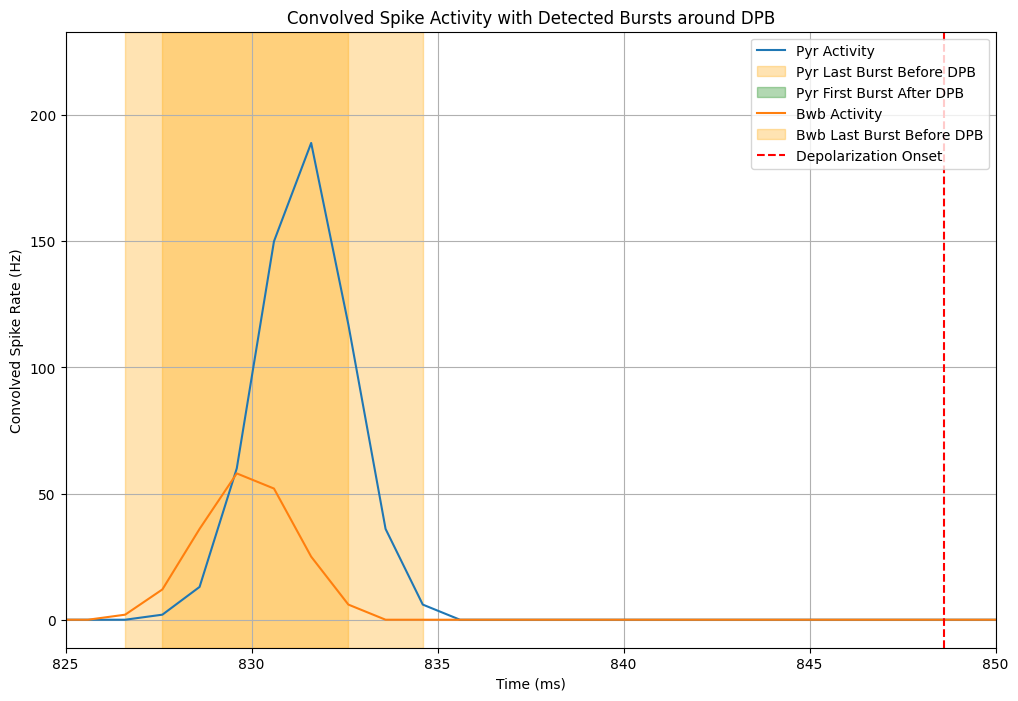

In [34]:
plot_convolved_activities_and_bursts(
    convolved_activities, burst_info, depolarization_onset
)

In [35]:
pkl_path = "/home/Marc/Marc_network_sims/Results/burst_analysis_results.pkl"

try:
    with open(pkl_path, "rb") as file:
        results = pickle.load(file)
    print(f"Data loaded successfully from {pkl_path}.")
except Exception as e:
    print(f"Error loading the file {pkl_path}:", e)

Data loaded successfully from /home/Marc/Marc_network_sims/Results/burst_analysis_results.pkl.


In [36]:
print(results.keys())
print(results["00"].keys())
print(results["00"]["depolarization_onset"])
print(results["00"]["burst_info"])
print(results["00"]["convolved_activities"])

dict_keys(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14'])
dict_keys(['depolarization_onset', 'convolved_activities', 'burst_info'])
848.6
{'Pyr': {'last_burst_before_dpb': (826.6, 836.6, 54), 'first_burst_after_dpb': (876.1, 894.1, 53)}, 'Bwb': {'last_burst_before_dpb': (826.1, 834.6, 18), 'first_burst_after_dpb': None}}
{'Pyr': (array([748.6, 749.1, 749.6, 750.1, 750.6, 751.1, 751.6, 752.1, 752.6,
       753.1, 753.6, 754.1, 754.6, 755.1, 755.6, 756.1, 756.6, 757.1,
       757.6, 758.1, 758.6, 759.1, 759.6, 760.1, 760.6, 761.1, 761.6,
       762.1, 762.6, 763.1, 763.6, 764.1, 764.6, 765.1, 765.6, 766.1,
       766.6, 767.1, 767.6, 768.1, 768.6, 769.1, 769.6, 770.1, 770.6,
       771.1, 771.6, 772.1, 772.6, 773.1, 773.6, 774.1, 774.6, 775.1,
       775.6, 776.1, 776.6, 777.1, 777.6, 778.1, 778.6, 779.1, 779.6,
       780.1, 780.6, 781.1, 781.6, 782.1, 782.6, 783.1, 783.6, 784.1,
       784.6, 785.1, 785.6, 786.1, 786.6, 787.1, 787.6, 788.1, 7

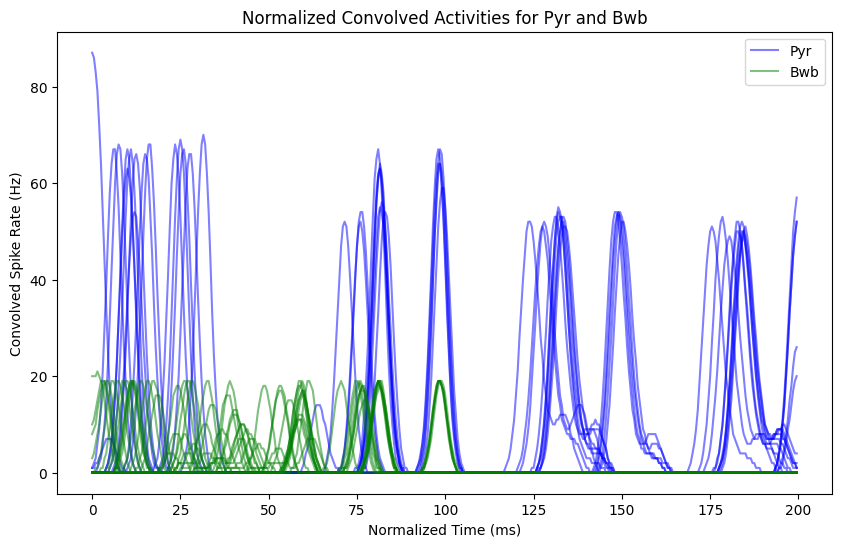

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store normalized activity data for plotting
pyr_activities = []
bwb_activities = []

# Process each trial
for trial_id in results.keys():
    for cell_type in ["Pyr", "Bwb"]:
        # Check if the cell type data is present in this trial
        if cell_type in results[trial_id]["convolved_activities"]:
            time_array, activity_array = results[trial_id]["convolved_activities"][
                cell_type
            ]

            # Normalize the time array to start from 0
            normalized_time = time_array - time_array[0]

            # Append the (normalized_time, activity_array) tuple to the correct list
            if cell_type == "Pyr":
                pyr_activities.append((normalized_time, activity_array))
            elif (
                cell_type == "Bwb" and activity_array.size > 0
            ):  # Ensure Bwb data exists
                bwb_activities.append((normalized_time, activity_array))

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Choose colors for each cell type
pyr_color = "blue"  # Color for Pyr activities
bwb_color = "green"  # Color for Bwb activities

# Plot Pyr activities with a single color
for time, activity in pyr_activities:
    ax.plot(time, activity, color=pyr_color, alpha=0.5, label="_nolegend_")

# Plot Bwb activities with a single color
for time, activity in bwb_activities:
    ax.plot(time, activity, color=bwb_color, alpha=0.5, label="_nolegend_")

# Add a single legend entry for each cell type
ax.plot([], [], color=pyr_color, alpha=0.5, label="Pyr")
ax.plot([], [], color=bwb_color, alpha=0.5, label="Bwb")

# Beautify the plot
ax.set_title("Normalized Convolved Activities for Pyr and Bwb")
ax.set_xlabel("Normalized Time (ms)")
ax.set_ylabel("Convolved Spike Rate (Hz)")
ax.legend(loc="best")

plt.show()

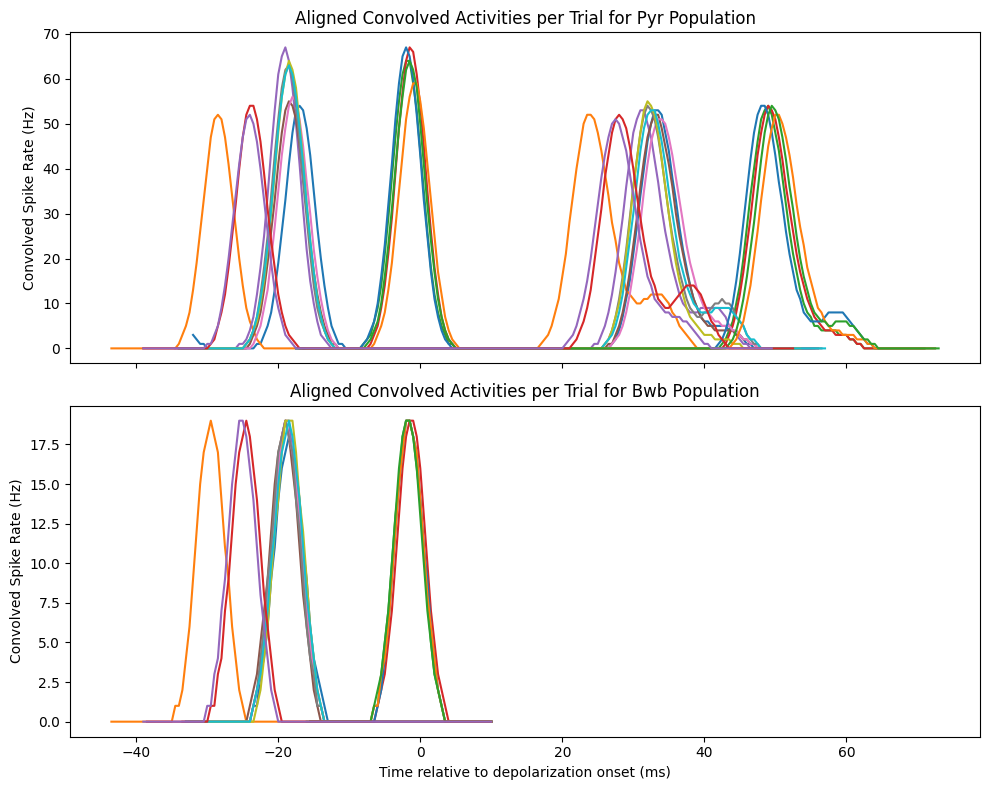

In [38]:
def align_bursts_to_depolarization_onset(results, cell_type, pre_post_margin=10):
    """
    Aligns bursts to the depolarization onset for each trial for a specified cell type.
    Only includes the last burst before and the first burst after depolarization onset if available.
    Adds a margin around the bursts for context.
    """
    aligned_activities = []

    for trial in results.values():
        depo_onset = trial["depolarization_onset"]
        burst_info = trial["burst_info"][cell_type]
        last_before = burst_info["last_burst_before_dpb"]
        first_after = burst_info["first_burst_after_dpb"]
        conv_times, conv_activities = trial["convolved_activities"][cell_type]

        # Determine time window to extract based on available bursts
        if last_before is not None:
            start_time = max(
                0, last_before[0] - pre_post_margin
            )  # Ensure non-negative start time
        else:
            start_time = max(0, depo_onset - pre_post_margin)

        if first_after is not None:
            end_time = first_after[1] + pre_post_margin
        else:
            end_time = depo_onset + pre_post_margin

        # Extract the relevant segment
        segment_mask = (conv_times >= start_time) & (conv_times <= end_time)
        times_segment = (
            conv_times[segment_mask] - depo_onset
        )  # Aligning to depolarization onset
        activities_segment = conv_activities[segment_mask]

        aligned_activities.append((times_segment, activities_segment))

    return aligned_activities


# Adjusted extraction for Pyr and Bwb, ensuring correct alignment
aligned_activities_pyr = align_bursts_to_depolarization_onset(results, "Pyr")
aligned_activities_bwb = align_bursts_to_depolarization_onset(results, "Bwb")

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
for times, activities in aligned_activities_pyr:
    ax[0].plot(times, activities, label="Pyr")
for times, activities in aligned_activities_bwb:
    ax[1].plot(times, activities, label="Bwb")

ax[0].set_title("Aligned Convolved Activities per Trial for Pyr Population")
# ax[0].legend()
ax[0].set_ylabel("Convolved Spike Rate (Hz)")
ax[1].set_title("Aligned Convolved Activities per Trial for Bwb Population")
ax[1].set_xlabel("Time relative to depolarization onset (ms)")
ax[1].set_ylabel("Convolved Spike Rate (Hz)")
# ax[1].legend()

plt.tight_layout()
plt.show()

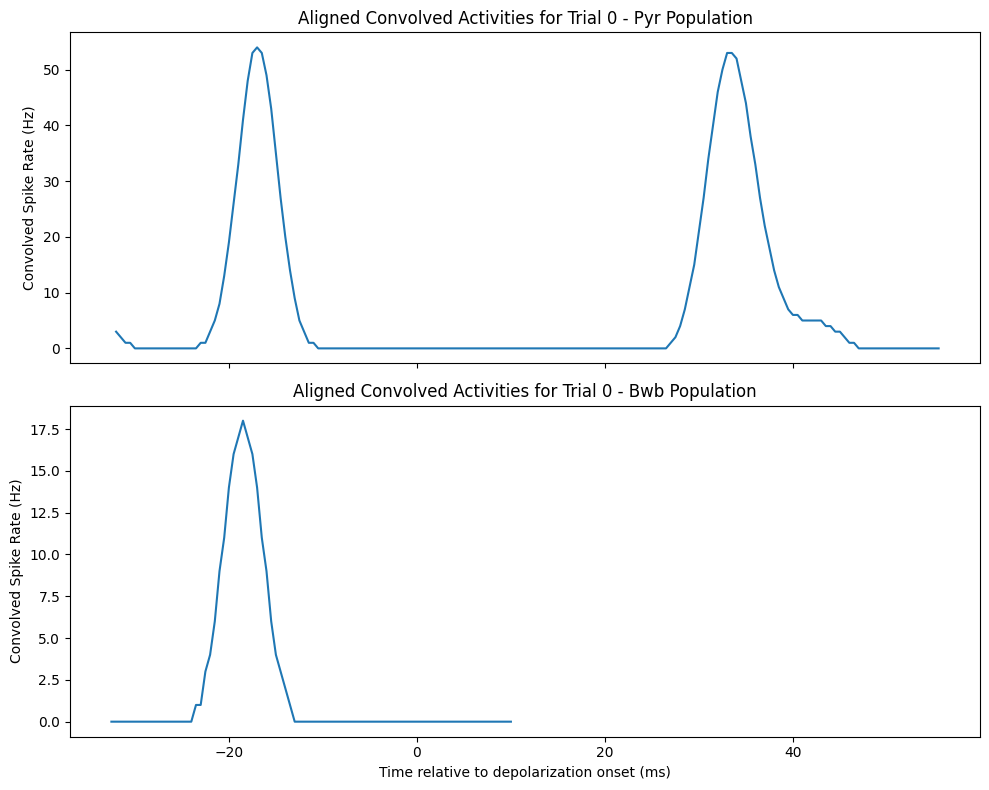

In [47]:
import matplotlib.pyplot as plt


def align_bursts_to_depolarization_onset(
    results, cell_type, trial_index, pre_post_margin=10
):
    """
    Aligns bursts to the depolarization onset for a single specified trial for a specified cell type.
    Only includes the last burst before and the first burst after depolarization onset if available.
    Adds a margin around the bursts for context.
    """
    # Extract the specific trial data based on trial_index
    trial_keys = list(results.keys())
    selected_trial_key = trial_keys[trial_index]
    trial = results[selected_trial_key]

    depo_onset = trial["depolarization_onset"]
    burst_info = trial["burst_info"][cell_type]
    last_before = burst_info["last_burst_before_dpb"]
    first_after = burst_info["first_burst_after_dpb"]
    conv_times, conv_activities = trial["convolved_activities"][cell_type]

    # Determine time window to extract based on available bursts
    if last_before is not None:
        start_time = max(
            0, last_before[0] - pre_post_margin
        )  # Ensure non-negative start time
    else:
        start_time = max(0, depo_onset - pre_post_margin)

    if first_after is not None:
        end_time = first_after[1] + pre_post_margin
    else:
        end_time = depo_onset + pre_post_margin

    # Extract the relevant segment
    segment_mask = (conv_times >= start_time) & (conv_times <= end_time)
    times_segment = (
        conv_times[segment_mask] - depo_onset
    )  # Aligning to depolarization onset
    activities_segment = conv_activities[segment_mask]

    return times_segment, activities_segment


# Adjusted call to only get and plot for a single trial for Pyr and Bwb
trial_index = 0  # Specify the trial index you want to plot
times_segment_pyr, activities_segment_pyr = align_bursts_to_depolarization_onset(
    results, "Pyr", trial_index
)
times_segment_bwb, activities_segment_bwb = align_bursts_to_depolarization_onset(
    results, "Bwb", trial_index
)

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax[0].plot(times_segment_pyr, activities_segment_pyr, label="Pyr")
ax[1].plot(times_segment_bwb, activities_segment_bwb, label="Bwb")

ax[0].set_title(
    f"Aligned Convolved Activities for Trial {trial_index} - Pyr Population"
)
ax[0].set_ylabel("Convolved Spike Rate (Hz)")
ax[1].set_title(
    f"Aligned Convolved Activities for Trial {trial_index} - Bwb Population"
)
ax[1].set_xlabel("Time relative to depolarization onset (ms)")
ax[1].set_ylabel("Convolved Spike Rate (Hz)")

plt.tight_layout()
plt.show()

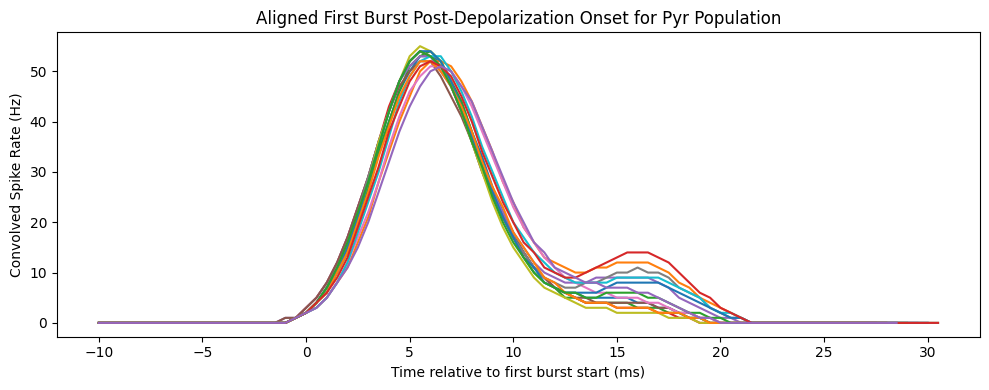

In [39]:
def align_first_burst_post_depolarization_onset(results, cell_type, pre_post_margin=10):
    """
    Aligns the first burst after the depolarization onset for each trial for a specified cell type.
    Adds a margin around the burst for context.
    """
    aligned_activities = []

    for trial in results.values():
        depo_onset = trial["depolarization_onset"]
        burst_info = trial["burst_info"][cell_type]
        first_after = burst_info["first_burst_after_dpb"]
        conv_times, conv_activities = trial["convolved_activities"][cell_type]

        if first_after is not None:
            # Extract the relevant segment with a margin
            start_time = max(0, first_after[0] - pre_post_margin)
            end_time = first_after[1] + pre_post_margin

            segment_mask = (conv_times >= start_time) & (conv_times <= end_time)
            times_segment = (
                conv_times[segment_mask] - first_after[0]
            )  # Aligning to first burst start
            activities_segment = conv_activities[segment_mask]

            aligned_activities.append((times_segment, activities_segment))

    return aligned_activities


# Assuming 'results' is your data structure containing trial data
aligned_activities_pyr_first_burst = align_first_burst_post_depolarization_onset(
    results, "Pyr"
)

# Plotting
plt.figure(figsize=(10, 4))
for times, activities in aligned_activities_pyr_first_burst:
    plt.plot(times, activities, label="Pyr First Burst Post-Depo")

plt.title("Aligned First Burst Post-Depolarization Onset for Pyr Population")
plt.xlabel("Time relative to first burst start (ms)")
plt.ylabel("Convolved Spike Rate (Hz)")
plt.tight_layout()
plt.show()

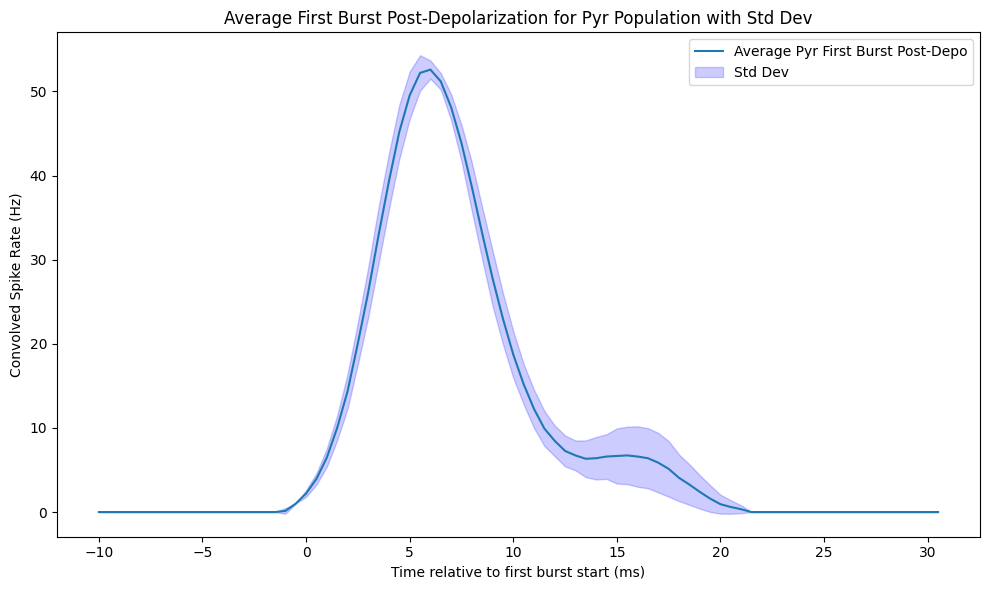

In [40]:
def calculate_mean_and_std_activities(aligned_activities):
    """
    Calculates the mean and standard deviation of aligned activities across trials.
    Assumes that all activities are aligned to the same relative start time.
    """
    # Determine the longest time range to standardize activity lengths
    max_length = max(len(times) for times, _ in aligned_activities)
    standardized_activities = np.full((len(aligned_activities), max_length), np.nan)

    for i, (times, activities) in enumerate(aligned_activities):
        standardized_activities[i, : len(activities)] = activities

    # Calculate mean and standard deviation, ignoring NaNs
    mean_activities = np.nanmean(standardized_activities, axis=0)
    std_activities = np.nanstd(standardized_activities, axis=0)

    # Use the longest time array for x-axis
    longest_times = aligned_activities[
        np.argmax([len(times) for times, _ in aligned_activities])
    ][0]

    return longest_times, mean_activities, std_activities


# Assuming 'aligned_activities_pyr_first_burst' contains your aligned activities for Pyr cells
longest_times, mean_activities, std_activities = calculate_mean_and_std_activities(
    aligned_activities_pyr_first_burst
)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(longest_times, mean_activities, label="Average Pyr First Burst Post-Depo")
plt.fill_between(
    longest_times,
    mean_activities - std_activities,
    mean_activities + std_activities,
    color="blue",
    alpha=0.2,
    label="Std Dev",
)

plt.title("Average First Burst Post-Depolarization for Pyr Population with Std Dev")
plt.xlabel("Time relative to first burst start (ms)")
plt.ylabel("Convolved Spike Rate (Hz)")
plt.legend()
plt.tight_layout()
plt.show()

What the above burst aligned to?


In [41]:
def align_last_burst_pre_depolarization_onset(results, cell_type, pre_post_margin=10):
    """
    Aligns the last burst before the depolarization onset for each trial for a specified cell type.
    Adds a margin around the burst for context.
    """
    aligned_activities = []

    for trial in results.values():
        depo_onset = trial["depolarization_onset"]
        burst_info = trial["burst_info"][cell_type]
        last_before = burst_info["last_burst_before_dpb"]
        conv_times, conv_activities = trial["convolved_activities"][cell_type]

        if last_before is not None:
            # Extract the relevant segment with a margin
            start_time = max(0, last_before[0] - pre_post_margin)
            end_time = min(
                last_before[1] + pre_post_margin, depo_onset
            )  # Ensure it does not go beyond depolarization onset

            segment_mask = (conv_times >= start_time) & (conv_times <= end_time)
            times_segment = (
                conv_times[segment_mask] - last_before[0]
            )  # Aligning to last burst start before depo
            activities_segment = conv_activities[segment_mask]

            aligned_activities.append((times_segment, activities_segment))

    return aligned_activities

In [42]:
aligned_activities_pyr_last_burst = align_last_burst_pre_depolarization_onset(
    results, "Pyr"
)
aligned_activities_bwb_last_burst = align_last_burst_pre_depolarization_onset(
    results, "Bwb"
)

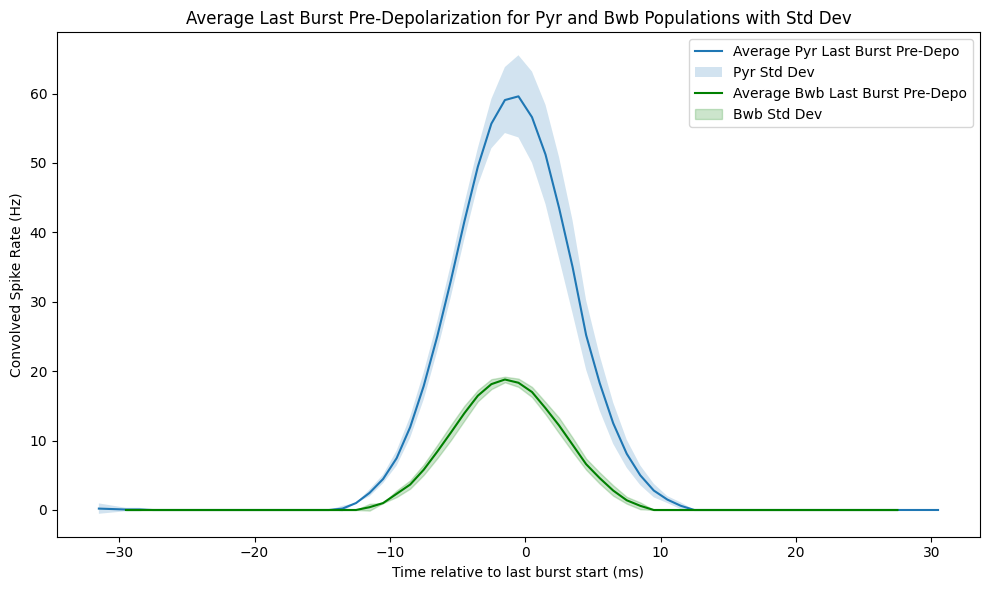

In [43]:
# Calculate mean and standard deviation for Pyr and Bwb cells
(
    longest_times_pyr,
    mean_activities_pyr,
    std_activities_pyr,
) = calculate_mean_and_std_activities(aligned_activities_pyr_last_burst)
(
    longest_times_bwb,
    mean_activities_bwb,
    std_activities_bwb,
) = calculate_mean_and_std_activities(aligned_activities_bwb_last_burst)

# Ensure both cell types use the same time axis for plotting
max_length = max(len(longest_times_pyr), len(longest_times_bwb))
time_axis = np.arange(-max_length / 2, max_length / 2)


# Adjust mean and std arrays to fit the new time axis (if necessary)
def adjust_activities_to_time_axis(mean_activities, std_activities, new_length):
    adjusted_mean = np.full(new_length, np.nan)
    adjusted_std = np.full(new_length, np.nan)
    start_index = (new_length - len(mean_activities)) // 2
    adjusted_mean[start_index : start_index + len(mean_activities)] = mean_activities
    adjusted_std[start_index : start_index + len(std_activities)] = std_activities
    return adjusted_mean, adjusted_std


adjusted_mean_pyr, adjusted_std_pyr = adjust_activities_to_time_axis(
    mean_activities_pyr, std_activities_pyr, max_length
)
adjusted_mean_bwb, adjusted_std_bwb = adjust_activities_to_time_axis(
    mean_activities_bwb, std_activities_bwb, max_length
)

# Plotting
plt.figure(figsize=(10, 6))

# Pyramidal cells
plt.plot(time_axis, adjusted_mean_pyr, label="Average Pyr Last Burst Pre-Depo")
plt.fill_between(
    time_axis,
    adjusted_mean_pyr - adjusted_std_pyr,
    adjusted_mean_pyr + adjusted_std_pyr,
    alpha=0.2,
    label="Pyr Std Dev",
)

# Basket cells
plt.plot(
    time_axis, adjusted_mean_bwb, color="green", label="Average Bwb Last Burst Pre-Depo"
)
plt.fill_between(
    time_axis,
    adjusted_mean_bwb - adjusted_std_bwb,
    adjusted_mean_bwb + adjusted_std_bwb,
    color="green",
    alpha=0.2,
    label="Bwb Std Dev",
)

plt.title(
    "Average Last Burst Pre-Depolarization for Pyr and Bwb Populations with Std Dev"
)
plt.xlabel("Time relative to last burst start (ms)")
plt.ylabel("Convolved Spike Rate (Hz)")
plt.legend()
plt.tight_layout()
plt.show()

What is the above plot aligned to exactly?


## TODO

- Plot the pre-ictal, ictal and interictal bursting activity for both populations -> Timeslices of the above plot. So after dpb burst, pre dpb burst, and around dpb burst.
- Get the results for +25-25% conductance trials for the 1.00 noise conditions (5 total \* 15 trials
- Correct the convolution method for spike times -> double check, relatively low resolution
- Make the mean plots over the trials. Perhaps do a fill between version of the plot.
- Make the basket cells overlap the pyramidal cells in the plot instead of splitting them.
- determine the distance between the peaks of basket cell and pyramidal burst
- Do a statistical test (man-whitney, KS, etc) to compare?


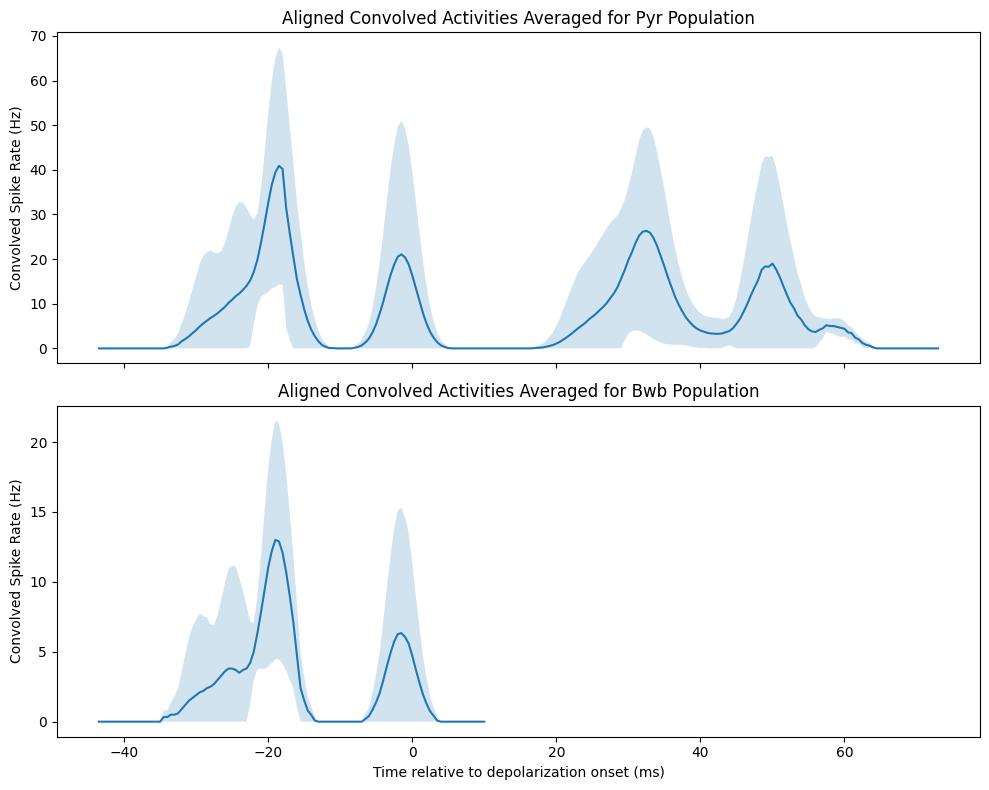

In [44]:
def aggregate_activities(aligned_activities):
    """
    Aggregate activities and compute mean and standard deviation for plotting.
    Assumes aligned_activities is a list of tuples (times, activities) for each trial.
    """
    # Concatenate all times and activities, assuming they're already aligned
    all_times = np.concatenate([times for times, _ in aligned_activities])
    all_activities = np.concatenate(
        [activities for _, activities in aligned_activities]
    )

    # Get unique times and initialize arrays for mean and std
    unique_times = np.unique(all_times)
    mean_activities = np.zeros_like(unique_times)
    std_activities = np.zeros_like(unique_times)

    # Compute mean and std for each unique time
    for i, time in enumerate(unique_times):
        activities_at_time = all_activities[all_times == time]
        mean_activities[i] = np.mean(activities_at_time)
        std_activities[i] = np.std(activities_at_time)

    return unique_times, mean_activities, std_activities


# Assuming results is defined, and align_bursts_to_depolarization_onset is already provided
aligned_activities_pyr = align_bursts_to_depolarization_onset(results, "Pyr")
aligned_activities_bwb = align_bursts_to_depolarization_onset(results, "Bwb")

# Aggregate activities and compute mean and std for each population
times_pyr, mean_activities_pyr, std_activities_pyr = aggregate_activities(
    aligned_activities_pyr
)
times_bwb, mean_activities_bwb, std_activities_bwb = aggregate_activities(
    aligned_activities_bwb
)

# Plotting with fill-between for deviation with lower bound at zero
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)


# Define a function to replace the lambda expression for clipping values
def clip_below_zero(values):
    return np.clip(values, a_min=0, a_max=None)


# Pyr Population
ax[0].plot(times_pyr, mean_activities_pyr, label="Pyr Mean")
ax[0].fill_between(
    times_pyr,
    clip_below_zero(mean_activities_pyr - std_activities_pyr),
    mean_activities_pyr + std_activities_pyr,
    alpha=0.2,
)
ax[0].set_title("Aligned Convolved Activities Averaged for Pyr Population")
ax[0].set_ylabel("Convolved Spike Rate (Hz)")

# Bwb Population
ax[1].plot(times_bwb, mean_activities_bwb, label="Bwb Mean")
ax[1].fill_between(
    times_bwb,
    clip_below_zero(mean_activities_bwb - std_activities_bwb),
    mean_activities_bwb + std_activities_bwb,
    alpha=0.2,
)
ax[1].set_title("Aligned Convolved Activities Averaged for Bwb Population")
ax[1].set_xlabel("Time relative to depolarization onset (ms)")
ax[1].set_ylabel("Convolved Spike Rate (Hz)")

plt.tight_layout()
plt.show()

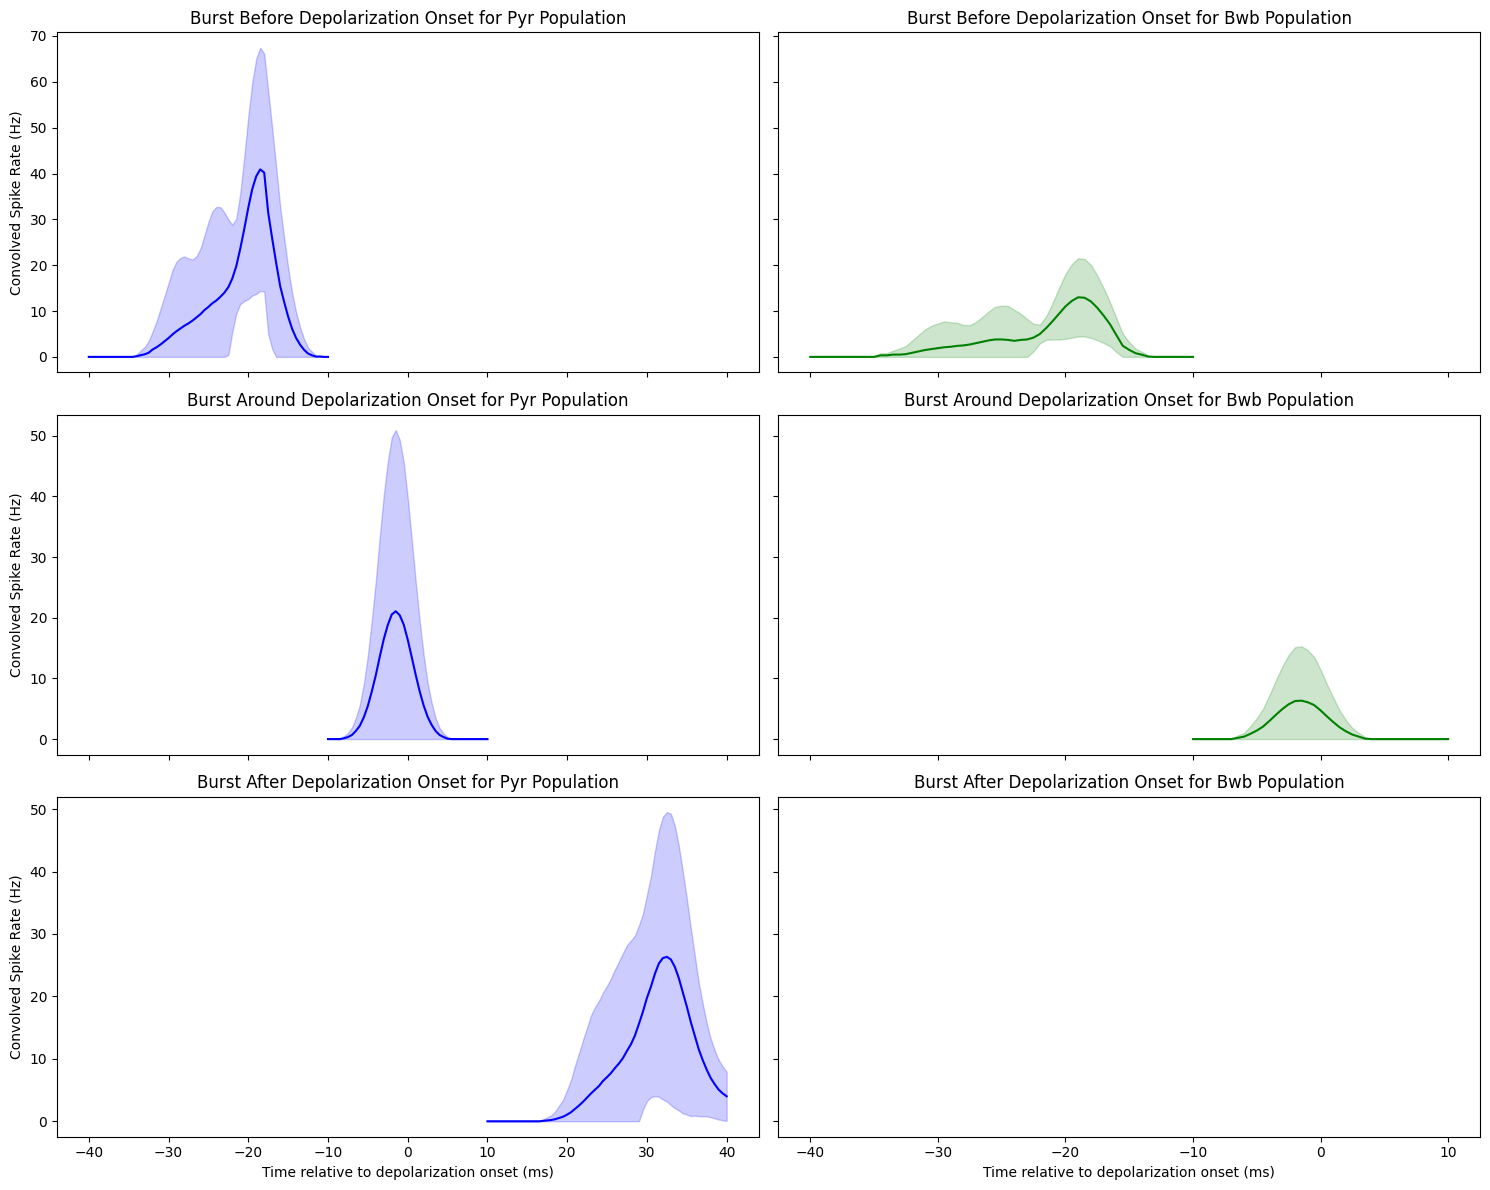

In [45]:
def plot_segment(
    ax, times, mean_activities, std_activities, time_window, title, color="blue"
):
    # Mask for the time window
    mask = (times >= time_window[0]) & (times <= time_window[1])
    # Plotting mean and fill_between for the time segment with specified color
    ax.plot(times[mask], mean_activities[mask], label=title, color=color)
    ax.fill_between(
        times[mask],
        clip_below_zero(mean_activities[mask] - std_activities[mask]),
        mean_activities[mask] + std_activities[mask],
        color=color,
        alpha=0.2,
    )
    ax.set_title(title)
    ax.set_ylabel("Convolved Spike Rate (Hz)")


# Assuming the rest of your code for data preparation goes here

# Define time windows and titles as before
time_windows = [(-40, -10), (-10, 10), (10, 40)]
titles = [
    "Burst Before Depolarization Onset",
    "Burst Around Depolarization Onset",
    "Burst After Depolarization Onset",
]

# Create figure with subplots for each time window and population
fig, axs = plt.subplots(
    len(time_windows), 2, figsize=(15, 12), sharex="col", sharey="row"
)

for i, time_window in enumerate(time_windows):
    # Plot for Pyr population with the default color
    plot_segment(
        axs[i][0],
        times_pyr,
        mean_activities_pyr,
        std_activities_pyr,
        time_window,
        titles[i] + " for Pyr Population",
    )

    # Plot for Bwb population with green color
    plot_segment(
        axs[i][1],
        times_bwb,
        mean_activities_bwb,
        std_activities_bwb,
        time_window,
        titles[i] + " for Bwb Population",
        color="green",
    )

for ax in axs.flat:
    ax.label_outer()

axs[-1][0].set_xlabel("Time relative to depolarization onset (ms)")
axs[-1][1].set_xlabel("Time relative to depolarization onset (ms)")

plt.tight_layout()
plt.show()

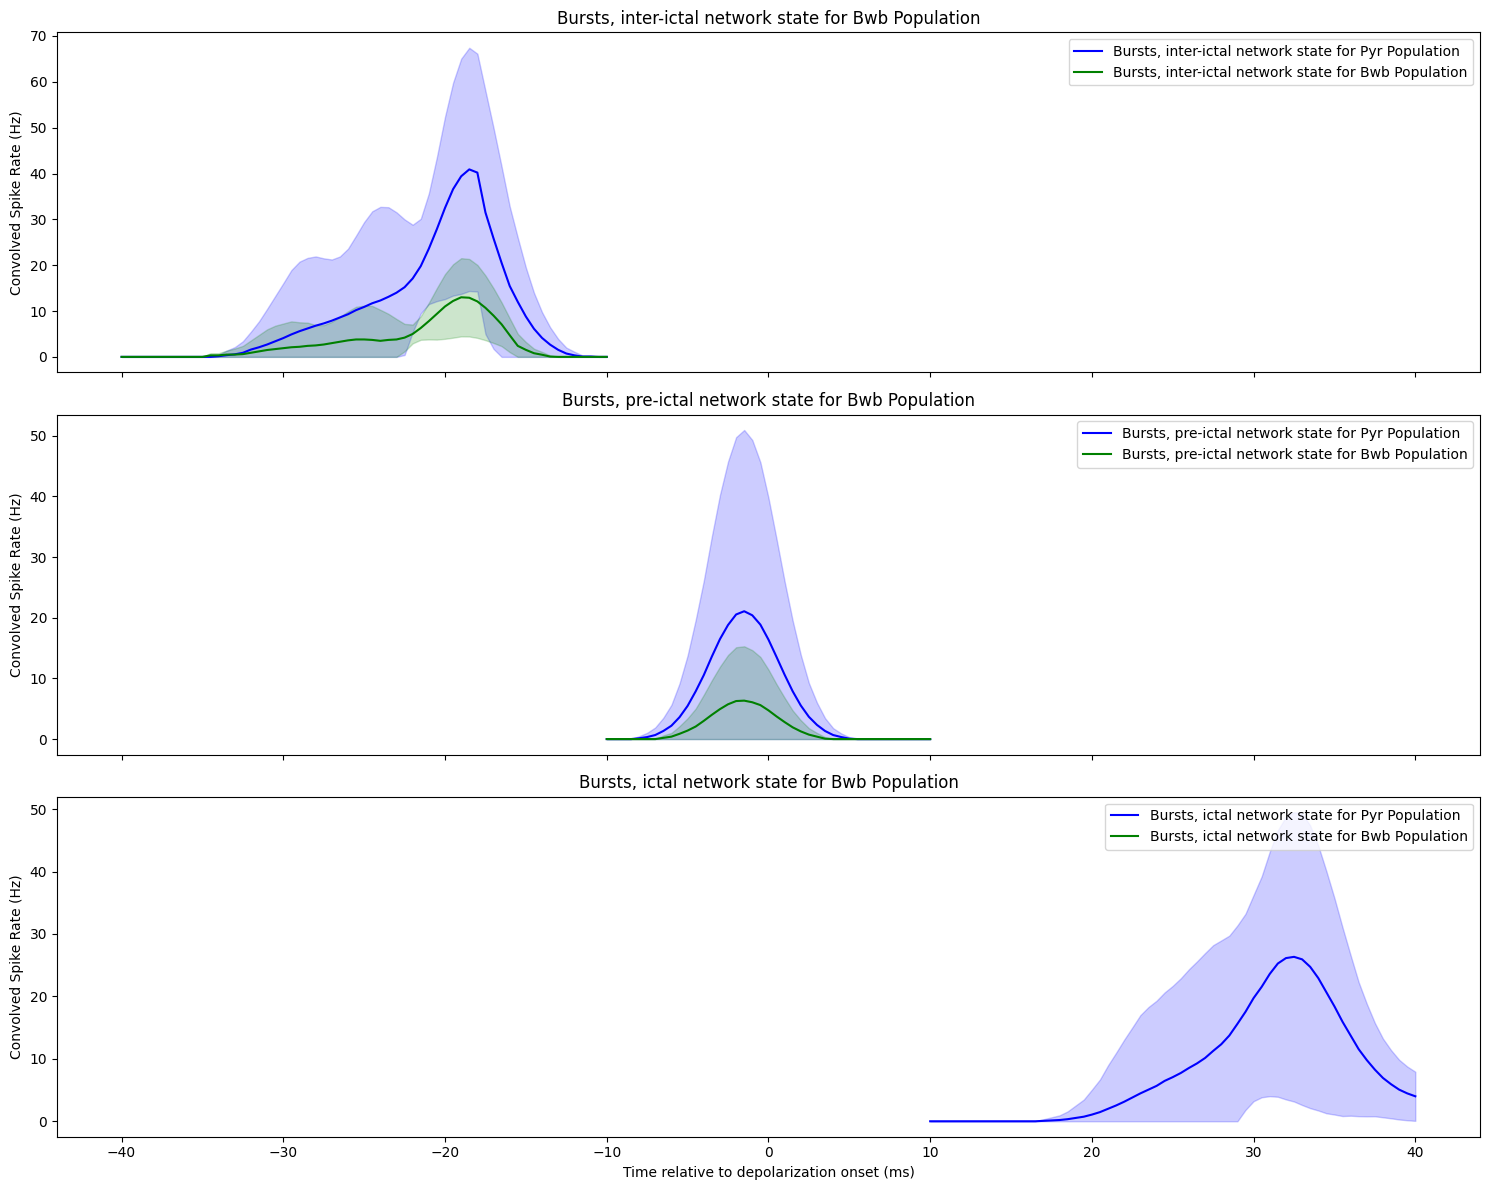

In [46]:
def plot_segment(
    ax, times, mean_activities, std_activities, time_window, title, color="blue"
):
    # Mask for the time window
    mask = (times >= time_window[0]) & (times <= time_window[1])
    # Plotting mean and fill_between for the time segment with specified color
    ax.plot(times[mask], mean_activities[mask], label=title, color=color)
    ax.fill_between(
        times[mask],
        clip_below_zero(mean_activities[mask] - std_activities[mask]),
        mean_activities[mask] + std_activities[mask],
        color=color,
        alpha=0.2,
    )
    ax.set_title(title)
    ax.set_ylabel("Convolved Spike Rate (Hz)")


# Assuming the rest of your code for data preparation goes here

# Define time windows and titles as before
time_windows = [(-40, -10), (-10, 10), (10, 40)]
titles = [
    "Bursts, inter-ictal network state",
    "Bursts, pre-ictal network state",
    "Bursts, ictal network state",
]

# Create figure with subplots for each time window, only for Pyr now as we'll include Bwb in the same plot
fig, axs = plt.subplots(len(time_windows), 1, figsize=(15, 12), sharex=True)

if len(time_windows) == 1:  # Ensure axs is always an array
    axs = [axs]

for i, time_window in enumerate(time_windows):
    # Plot for Pyr population with the default color
    plot_segment(
        axs[i],
        times_pyr,
        mean_activities_pyr,
        std_activities_pyr,
        time_window,
        titles[i] + " for Pyr Population",
    )

    # Overlay Plot for Bwb population with green color on the same subplot
    plot_segment(
        axs[i],
        times_bwb,
        mean_activities_bwb,
        std_activities_bwb,
        time_window,
        titles[i] + " for Bwb Population",
        color="green",
    )

    axs[i].legend()  # Add a legend to distinguish between Pyr and Bwb

axs[-1].set_xlabel("Time relative to depolarization onset (ms)")

plt.tight_layout()
plt.show()